# Effective Python: A Selection of Five Ways to Write Better Python

## Profile Before Optimizing

- Multy-year projects can have lots of moving parts.
- Finding inefficiencies can be hard.
- Profiling allows you to figure out exactly which functions are slowing down the code.

### Example: Solving the Bateman Equation

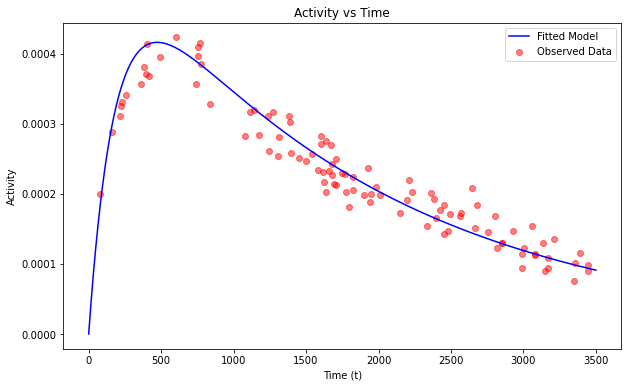

In [2]:
import numpy as np
import matplotlib.pyplot as plt

EPSILON = 1e-14
LEARNING_RATE = 0.0005
EPOCHS = 10000

def function(t, decay_rb, decay_sr):
    activity = ((decay_rb * decay_sr) / (decay_rb - decay_sr)) * \
                   (np.exp(-decay_sr * t) - np.exp(-decay_rb * t))
    return activity


def data_generator():
    decay_rb = 0.000504 # s^-1
    decay_sr = 0.00513  # s^-1
    
    t = np.random.uniform(0, 3500, 100)
    
    activity = function(t, decay_rb, decay_sr)
    
    noise = np.random.normal(0, 0.05 * np.max(activity), activity.shape)
    
    activity += noise
    return t, activity


def gradient_descent(x, y, learning_rate=LEARNING_RATE, epochs=EPOCHS):
    theta = [0.0001, 0.005]
    loss_history = []
    grads = np.zeros(2)
    
    m = np.zeros(2)
    v = np.zeros(2)
    beta1 = 0.9
    beta2 = 0.999
    t = 0
    
    for epoch in range(epochs):
        y_pred = function(x, theta[0], theta[1])
        
        residuals = y_pred - y
        loss = (1 / (2 * len(y))) * np.sum(residuals ** 2)
        loss_history.append(loss)
        
        for i in range(2):
            theta_copy = theta.copy()
            theta_copy[i] += EPSILON
            y_pred_epsilon = 0
            for _ in range(10):
                y_pred_epsilon = function(x, theta_copy[0], theta_copy[1])
            
            residuals_epsilon = y_pred_epsilon - y
            grads[i] = (1 / len(y)) * np.sum(residuals_epsilon)
        
        t += 1
        
        m = beta1 * m + (1 - beta1) * grads
        v = beta2 * v + (1 - beta2) * (grads ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        theta -= learning_rate * m_hat / (np.sqrt(v_hat) + EPSILON)
    return theta, loss_history


def main():
    t, y = data_generator()
    theta, loss_history = gradient_descent(t, y)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(t, y, label='Observed Data', color='red', alpha=0.5)
    plt.plot(np.linspace(0, 3500, 3500), function(np.linspace(0, 3500, 3500), theta[0], theta[1]), label='Fitted Model', color='blue')
    plt.xlabel('Time (t)')
    plt.ylabel('Activity')
    plt.title('Activity vs Time')
    plt.legend()
    plt.show()
    
    
main()

For such a simple process, the code takes a relatively long time. We can use cProfile to check where our inefficiencies occur.

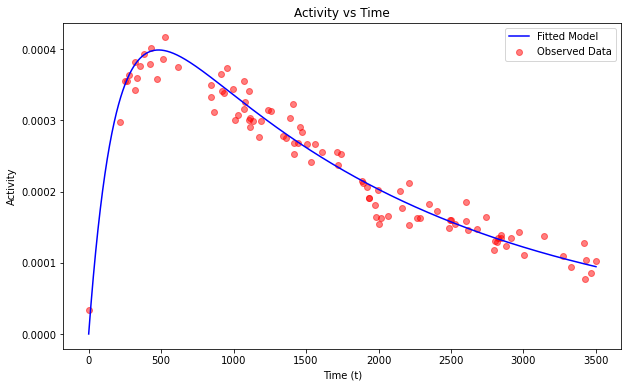

         724173 function calls (720260 primitive calls) in 1.641 seconds

   Ordered by: cumulative time
   List reduced from 1417 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.641    1.641 <ipython-input-2-6c3c280add87>:68(main)
        1    0.223    0.223    1.540    1.540 <ipython-input-2-6c3c280add87>:28(gradient_descent)
   210002    1.167    0.000    1.167    0.000 <ipython-input-2-6c3c280add87>:8(function)
    30000    0.009    0.000    0.102    0.000 <__array_function__ internals>:2(sum)
33172/32779    0.009    0.000    0.102    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.000    0.000    0.088    0.088 /opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py:252(show)
        1    0.000    0.000    0.088    0.088 /opt/anaconda3/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py:23(show)
    30000    0.016    0.000    0.084 

In [5]:
import cProfile
import pstats

with cProfile.Profile() as profiler:
    main()
    
stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(20)


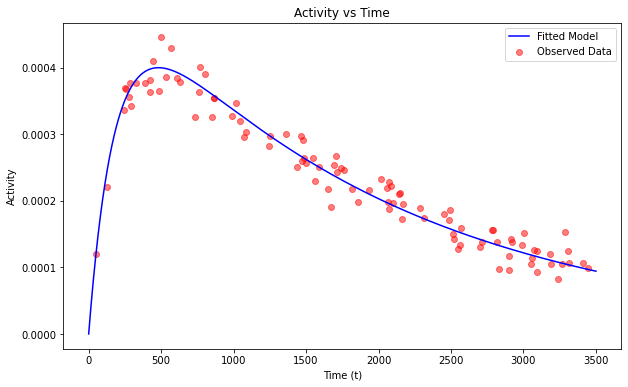

         543992 function calls (540183 primitive calls) in 0.608 seconds

   Ordered by: cumulative time
   List reduced from 1410 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.608    0.608 <ipython-input-6-48a0f772110b>:38(optimised_main)
        1    0.161    0.161    0.504    0.504 <ipython-input-6-48a0f772110b>:1(gradient_descent_optimised)
    30002    0.190    0.000    0.190    0.000 <ipython-input-2-6c3c280add87>:8(function)
    30000    0.009    0.000    0.109    0.000 <__array_function__ internals>:2(sum)
33172/32779    0.009    0.000    0.108    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.000    0.000    0.093    0.093 /opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py:252(show)
        1    0.000    0.000    0.093    0.093 /opt/anaconda3/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py:23(show)
    30000    0.017

In [6]:
def gradient_descent_optimised(x, y, learning_rate=LEARNING_RATE, epochs=EPOCHS):
    theta = [0.0001, 0.005]
    loss_history = []
    grads = np.zeros(2)
    
    m = np.zeros(2)
    v = np.zeros(2)
    beta1 = 0.9
    beta2 = 0.999
    t = 0
    
    for epoch in range(epochs):
        y_pred = function(x, theta[0], theta[1])
        
        residuals = y_pred - y
        loss = (1 / (2 * len(y))) * np.sum(residuals ** 2)
        loss_history.append(loss)
        
        for i in range(2):
            theta_copy = theta.copy()
            theta_copy[i] += EPSILON
            y_pred_epsilon = function(x, theta_copy[0], theta_copy[1])
            
            residuals_epsilon = y_pred_epsilon - y
            grads[i] = (1 / len(y)) * np.sum(residuals_epsilon)
        
        t += 1
        
        m = beta1 * m + (1 - beta1) * grads
        v = beta2 * v + (1 - beta2) * (grads ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        theta -= learning_rate * m_hat / (np.sqrt(v_hat) + EPSILON)
    return theta, loss_history

def optimised_main():
    t, y = data_generator()
    theta, loss_history = gradient_descent_optimised(t, y)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(t, y, label='Observed Data', color='red', alpha=0.5)
    plt.plot(np.linspace(0, 3500, 3500), function(np.linspace(0, 3500, 3500), theta[0], theta[1]), label='Fitted Model', color='blue')
    plt.xlabel('Time (t)')
    plt.ylabel('Activity')
    plt.title('Activity vs Time')
    plt.legend()
    plt.show()
    
with cProfile.Profile() as profiler:
    optimised_main()
    
stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(20)

## Consider concurrent.futures for True Parallelism

- Modern hardware is made to handle tasks in parallel.
- By running multiple operations at the same time, we reduce computing time.
- Very useful for combinatorial optimisation.

### Example: Bayesian Optimization

[0.0005198224963974019, 0.004671460642047304]


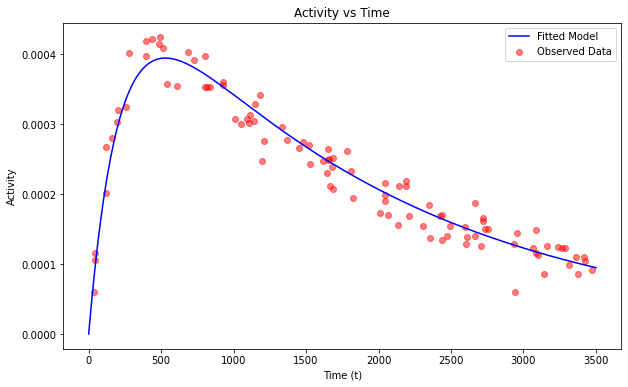

In [12]:
from skopt import gp_minimize
from skopt.space import Real


def objective(theta, t, y):
    y_pred = function(t, theta[0], theta[1])
    residuals = y_pred - y
    loss = (1 / (2 * len(y))) * np.sum(residuals ** 2)
    return loss

def bayes_optimiser(t, y):
    objective_with_data = lambda theta: objective(theta, t, y)
    space = [Real(0, 0.001, name="theta_0"), 
             Real(0, 0.01, name="theta_1")]
    result = gp_minimize(objective_with_data, space, n_calls=100, random_state=0)
    optimal_theta = result.x
    return optimal_theta
        

def main_bayes():
    t, y = data_generator()
    theta = bayes_optimiser(t, y)
    print(theta)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(t, y, label='Observed Data', color='red', alpha=0.5)
    plt.plot(np.linspace(0, 3500, 3500), function(np.linspace(0, 3500, 3500), theta[0], theta[1]), label='Fitted Model', color='blue')
    plt.xlabel('Time (t)')
    plt.ylabel('Activity')
    plt.title('Activity vs Time')
    plt.legend()
    plt.show()


main_bayes()


[0.0004605112905294998, 0.005856933838297361]


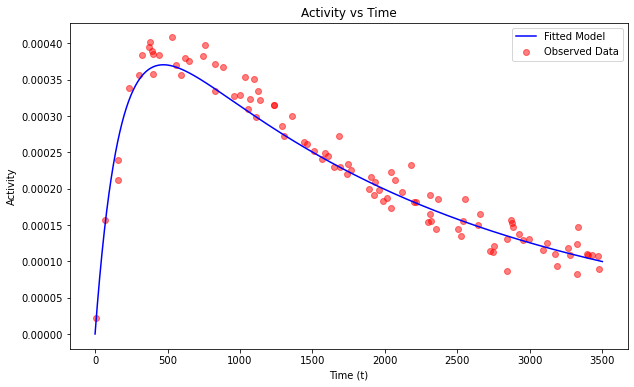

In [26]:
from skopt import Optimizer
import concurrent.futures


def bayes_optimiser_concurrent(t, y, epochs=15):
    objective_with_data = lambda theta: objective(theta, t, y)
    space = [Real(0, 0.001, name="theta_0"), 
             Real(0, 0.01, name="theta_1")]
    optimizer = Optimizer(space, random_state=0)
    
    results = []
    best_theta = [0, 0]
    for _ in range(epochs):
        candidates = optimizer.ask(4)
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [executor.submit(objective_with_data, theta) for theta in candidates]
            losses = [future.result() for future in concurrent.futures.as_completed(futures)]
        
        for theta, loss in zip(candidates, losses):
            optimizer.tell(theta, loss)
            results.append((theta, loss))
            
        results.sort(key=lambda x: x[1])
        best_theta, best_loss = results[0]
    return best_theta


def main_bayes_concurrent():
    t, y = data_generator()
    theta = bayes_optimiser_concurrent(t, y)
    print(theta)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(t, y, label='Observed Data', color='red', alpha=0.5)
    plt.plot(np.linspace(0, 3500, 3500), function(np.linspace(0, 3500, 3500), theta[0], theta[1]), label='Fitted Model', color='blue')
    plt.xlabel('Time (t)')
    plt.ylabel('Activity')
    plt.title('Activity vs Time')
    plt.legend()
    plt.show()
    

main_bayes_concurrent()

## Use Mocks to Test Code with Complex Dependencies

- ML techniques often require a lot of computing power.
- When debugging, this can be cumbersome.
- Mocking allows us to debug or opitimize specific sections of code by generating mock data.
- This can be especially useful in RL.

### Example: Genetic Algorithm


In [16]:
import random


def create_population(size, bounds):
    population = []
    for _ in range(size):
        while True:
            theta = [random.uniform(*bound) for bound in bounds]
            if theta[0] != theta[1]:
                population.append(theta)
                break
    return population

def mutate(theta, bounds, mutation_rate=0.1):
    new_theta = []
    for gene, (lower, upper) in zip(theta, bounds):
        if random.random() < mutation_rate:
            mutation = random.uniform(-0.1, 0.1) 
            new_gene = gene + mutation
            new_gene = max(lower, min(upper, new_gene))
        else:
            new_gene = gene
        new_theta.append(new_gene)
    return new_theta


def crossover(parent1, parent2):
    return [(gene1 + gene2) / 2 for gene1, gene2 in zip(parent1, parent2)]


def genetic_algorithm(bounds, t, y, population_size=100, generations=100):
    population = create_population(population_size, bounds)
    objective_with_data = lambda theta: objective(theta, t, y)
    
    for _ in range(generations):
        scores = [(theta, objective_with_data(theta)) for theta in population]
        scores.sort(key=lambda x: x[1])
        population = [x[0] for x in scores]
        
        selected = population[:population_size // 2]
        next_gen = []
        for i in range(population_size):
            parent1 = random.choice(selected)
            parent2 = random.choice(selected)
            child = crossover(parent1, parent2)
            child = mutate(child, bounds)
            next_gen.append(child)
        population = next_gen
        
    best_individual = min(population, key=lambda theta: objective(theta, t, y))
    return best_individual


def main_ga():
    t, y = data_generator()
    bounds = [(0, 0.001), (0, 0.01)]
    theta = genetic_algorithm(bounds, t, y)
    print("Optimal theta:", theta)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(t, y, label='Observed Data', color='red', alpha=0.5)
    plt.plot(np.linspace(0, 3500, 3500), function(np.linspace(0, 3500, 3500), theta[0], theta[1]), label='Fitted Model', color='blue')
    plt.xlabel('Time (t)')
    plt.ylabel('Activity')
    plt.title('Activity vs Time')
    plt.legend()
    plt.show()
    

main_ga()

ZeroDivisionError: division by zero

In [55]:
import unittest


class TestGeneticAlgorithm(unittest.TestCase):
    
    def test_mutate_creates_invalid_individual(self):
        bounds = [(0, 0.001), (0, 0.01)]
        population = create_population(10, bounds)
        
        found_equal = False
        for theta in population:
            mutated = mutate(theta, bounds)
            if mutated[0] == mutated[1]:
                found_equal = True
                break

        self.assertTrue(found_equal, 
                        "Mutate function produced equal theta values when it shouldn't!")


unittest.main(argv=[''], exit=False)

F
FAIL: test_mutate_creates_invalid_individual (__main__.TestGeneticAlgorithm)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-55-44a7b3e96747>", line 17, in test_mutate_creates_invalid_individual
    self.assertTrue(found_equal,
AssertionError: False is not true : Mutate function produced equal theta values when it shouldn't!

----------------------------------------------------------------------
Ran 1 test in 0.001s

FAILED (failures=1)


Optimal theta: [0.0005047126636390439, 0.005729488995138313]


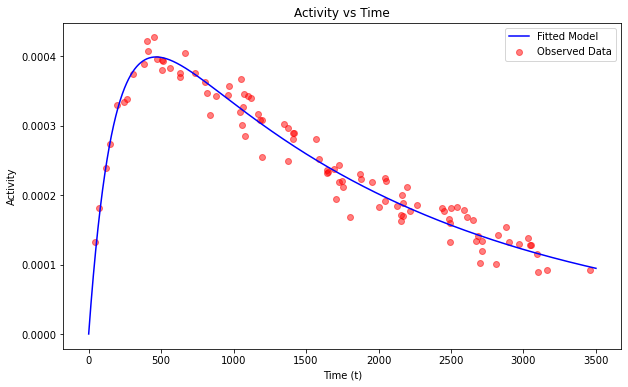

In [18]:
def mutate_fixed(theta, bounds, mutation_rate=0.1):
    new_theta = []
    for gene, (lower, upper) in zip(theta, bounds):
        if random.random() < mutation_rate:
            mutation = random.uniform(-0.1, 0.1) 
            new_gene = gene + mutation
            new_gene = max(lower, min(upper, new_gene))
        else:
            new_gene = gene
        new_theta.append(new_gene)
    
    if abs(new_theta[0] - new_theta[1]) < 0.00000001:
        new_theta[1] += 0.00000001
    return new_theta


def genetic_algorithm_fixed(bounds, t, y, population_size=100, generations=100):
    objective_with_data = lambda theta: objective(theta, t, y)
    population = create_population(population_size, bounds)
    
    for _ in range(generations):
        scores = [(theta, objective_with_data(theta)) for theta in population]
        scores.sort(key=lambda x: x[1])
        population = [x[0] for x in scores]
        
        selected = population[:population_size // 2]
        next_gen = []
        for i in range(population_size):
            parent1 = random.choice(selected)
            parent2 = random.choice(selected)
            child = crossover(parent1, parent2)
            child = mutate_fixed(child, bounds)
            next_gen.append(child)
        population = next_gen
        
    best_individual = min(population, key=lambda theta: objective(theta, t, y))
    return best_individual


def main_ga_fixed():
    t, y = data_generator()
    bounds = [(0, 0.001), (0, 0.01)]
    theta = genetic_algorithm_fixed(bounds, t, y)
    print("Optimal theta:", theta)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(t, y, label='Observed Data', color='red', alpha=0.5)
    plt.plot(np.linspace(0, 3500, 3500), function(np.linspace(0, 3500, 3500), theta[0], theta[1]), label='Fitted Model', color='blue')
    plt.xlabel('Time (t)')
    plt.ylabel('Activity')
    plt.title('Activity vs Time')
    plt.legend()
    plt.show()
    

main_ga_fixed()

## Use Packages to Organize Modules and Provide Stable APIs

- As a program grows, it is useful to organize code into many modules.
- Eventually, as a program grows, another layer of organisation is needed to make the code understandable.
- Packages are modules that contain other modules.

### Example: Algorithm Tester



Gradient Descent: Theta = [0.0004732 0.0053732], Loss = 1.877837057892366e-10
Bayesian Optimization: Theta = [0.0005004673318281338, 0.004714674966929573], Loss = 1.693957371677158e-10
Genetic Algorithm: Theta = [0.0004909383433189319, 0.005338928475832748], Loss = 1.6814647842105306e-10

Best Algorithm: Genetic Algorithm with Theta = [0.0004909383433189319, 0.005338928475832748] and Loss = 1.6814647842105306e-10


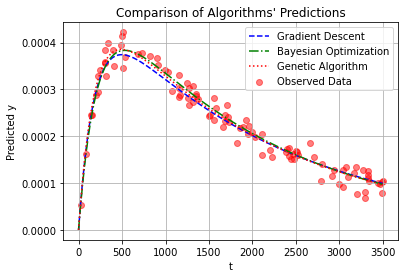

In [24]:
import Algorithms.grad_des as algd
import Algorithms.bayesian_opt as albo
import Algorithms.genetic_algo as alga
import functions.loss_function as loss


def main_test():
    """
    Runs an instance of gradient descent, bayesian optimisation and a genetic algorithm to solve the Bateman equation given some measured data. Plots the data and the three models. Prints out which of the three models has the lowest loss.
    :return: None
    """
    t, y = data_generator()
    bounds = [(0, 0.001), (0, 0.01)]

    theta_gd = algd.gradient_descent(t, y)
    theta_bo = albo.bayes_optimiser(t, y)
    theta_ga = alga.genetic_algo(bounds, t, y)

    loss_gd = loss.objective_fixed(theta_gd, t, y)
    loss_no = loss.objective_fixed(theta_bo, t, y)
    loss_ga = loss.objective_fixed(theta_ga, t, y)

    results = {
        'Gradient Descent': (theta_gd, loss_gd),
        'Bayesian Optimization': (theta_bo, loss_no),
        'Genetic Algorithm': (theta_ga, loss_ga)
    }

    best_algorithm = min(results.items(), key=lambda x: x[1][1])
    for name, (theta, obj) in results.items():
        print(f"{name}: Theta = {theta}, Loss = {obj}")

    print(
        f"\nBest Algorithm: {best_algorithm[0]} with Theta = {best_algorithm[1][0]} "
        f"and Loss = {best_algorithm[1][1]}")
    
    t_plot = np.linspace(0, 3500, 3500)
    
    y_gd = function(t_plot, theta_gd[0], theta_gd[1])
    y_bo = function(t_plot, theta_bo[0], theta_bo[1])
    y_ga = function(t_plot, theta_ga[0], theta_ga[1])
    
    plt.scatter(t, y, label='Observed Data', color='red', alpha=0.5)

    plt.plot(t_plot, y_gd, label="Gradient Descent", color="blue", linestyle="--")
    plt.plot(t_plot, y_bo, label="Bayesian Optimization", color="green", linestyle="-.")
    plt.plot(t_plot, y_ga, label="Genetic Algorithm", color="red", linestyle=":")

    plt.xlabel("t")
    plt.ylabel("Predicted y")
    plt.title("Comparison of Algorithms' Predictions")
    plt.legend()
    plt.grid(True)
    plt.show()
    

main_test()
    

## Write Docstrings for Every Function, Class, and Module

- Essential with collaborative or long term projects.
- Very important for reproducible AI.
- Facilitates automated documentation
